In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargar los datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/air_quality_data_preprocessed.csv')

In [4]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,16,2013,3,1,15,8.0,15.0,7.0,14.0,400.0,...,77.0,7.395833,6.500000,12.890625,22.265625,3141.176471,77.0,6,3141.0,Severe
1,17,2013,3,1,16,9.0,19.0,9.0,13.0,400.0,...,77.0,7.843137,7.235294,12.794118,21.911765,2552.941176,77.0,6,2553.0,Severe
2,18,2013,3,1,17,10.0,23.0,11.0,15.0,400.0,...,77.0,8.333333,8.111111,12.847222,21.736111,2552.941176,77.0,6,2553.0,Severe
3,19,2013,3,1,18,11.0,20.0,8.0,20.0,500.0,...,77.0,8.859649,8.736842,12.697368,21.907895,3141.176471,77.0,6,3141.0,Severe
4,20,2013,3,1,19,8.0,14.0,12.0,30.0,500.0,...,77.0,9.083333,9.000000,12.812500,22.687500,3141.176471,77.0,6,3141.0,Severe


In [5]:
data.shape

(31800, 33)

In [6]:
train_data = data[:23159][['AQI_calculated']]
test_data = data[23159:31801][['AQI_calculated']]

In [7]:
imputer = SimpleImputer(strategy='mean')
train_data_or = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns, index=train_data.index)


In [8]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 3)


In [9]:
X_train.shape

(23156, 3, 1)

In [10]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0013
Epoch 2/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0011
Epoch 3/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 9.7914e-04
Epoch 4/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 9.7309e-04
Epoch 5/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 8.5578e-04
Epoch 6/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0010
Epoch 7/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.8064e-04
Epoch 8/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 7.9647e-04
Epoch 9/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 9.1720e-04
Epoch 10/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.2184e-04
Epoch 11/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8.2771e-04
Epoch 12/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9.1064e-04
Epoch 13/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.1373e-04
Epoch 14/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 8.0900e-04

In [14]:
# Crear datos de entrada para predicción
X_test, _ = create_dataset(np.vstack([train_scaled[-3:], test_scaled]), 3)

# Predicciones
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 2))], axis=1))[:, 0]

# Datos reales para comparar
test_demand = scaler.inverse_transform(test_scaled)[:, 0]


271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


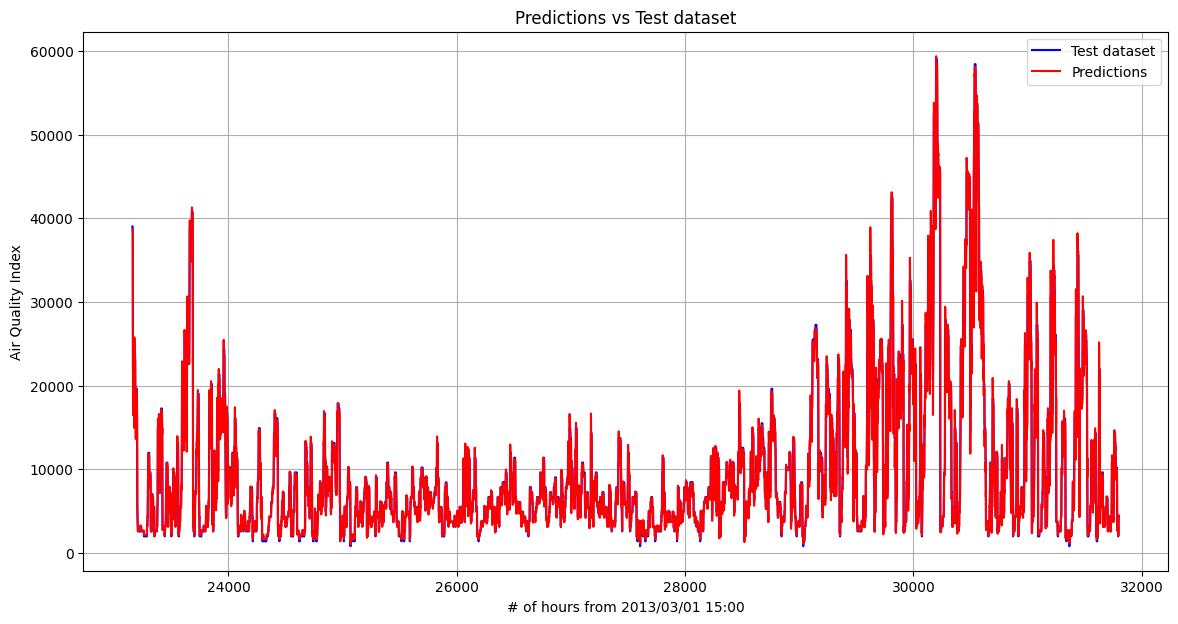

In [16]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_demand, label='Test dataset', color='blue')
plt.plot(test_data.index[:len(predictions)], predictions, label='Predictions', color='red')
plt.title('Predictions vs Test dataset')
plt.xlabel('# of hours from 2013/03/01 15:00')
plt.ylabel('Air Quality Index')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
test_demand = pd.Series(test_demand[:len(predictions)], index=test_data.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=test_data.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in test_demand.groupby(data.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared for month {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=test_data.index, y=test_demand, mode='lines', name='Test dataset', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=test_data.index[:len(predictions)], y=predictions, mode='lines', name='Predictions', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Predictions vs Test dataset',
    xaxis_title='# of hours from 2013/03/01 15:00',
    yaxis_title='Air Quality Index',

)

# Mostrar la gráfica
fig.show()

R-squared for month 1: 0.9813177237401681
R-squared for month 2: 0.9652297604570644
R-squared for month 3: 0.9784744432251834
R-squared for month 4: 0.9614499774234951
R-squared for month 5: 0.9587355149875545
R-squared for month 6: 0.9132351669671472
R-squared for month 7: 0.925840695493735
R-squared for month 8: 0.9282683772012927
R-squared for month 9: 0.9312958069374598
R-squared for month 10: 0.9653990775237379
R-squared for month 11: 0.9606512364096412
R-squared for month 12: 0.9690154107722001
